#1. Data Preparation


This section handles all the initial steps of preparing the data for modeling. It includes loading the dataset from the Kaggle source, defining the column headers, and cleaning the data by removing non-informative columns and checking for any missing values.



In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
behrad3d_nasa_cmaps_path = kagglehub.dataset_download('behrad3d/nasa-cmaps')
print('Data source import complete.')

# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define column names based on the dataset structure
columns = ['engine_id', 'cycle', 'setting_1', 'setting_2', 'setting_3'] + \
          ['sensor_' + str(i) for i in range(1, 22)]

# Load the training data from the specified path
# We use os.path.join to build a correct file path
# The data is space-separated, so sep=r'\s+' is used.
data_path = os.path.join(behrad3d_nasa_cmaps_path, 'CMaps', 'train_FD001.txt')
train_df = pd.read_csv(data_path, sep=r'\s+', header=None, names=columns)

# Check for any missing values across the dataset
missing_values_count = train_df.isnull().sum().sum()
print(f"Total missing values: {missing_values_count}")

# Identify and remove columns with constant values
# These columns provide no predictive power
constant_cols = [col for col in train_df.columns if train_df[col].nunique() <= 1]
train_df.drop(columns=constant_cols, inplace=True)

# Display the remaining columns after cleanup
print("\nRemaining columns after removing non-informative features:")
print(train_df.columns)

Using Colab cache for faster access to the 'nasa-cmaps' dataset.
Data source import complete.
Total missing values: 0

Remaining columns after removing non-informative features:
Index(['engine_id', 'cycle', 'setting_1', 'setting_2', 'sensor_2', 'sensor_3',
       'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17',
       'sensor_20', 'sensor_21'],
      dtype='object')


#2. EDA + Feature Building


This section is dedicated to exploring the data and engineering new features that will be used by the model. We'll calculate the Remaining Useful Life (RUL), create a binary target label for classification, and build a set of new time-series features using rolling statistics to capture trends over time.



In [2]:
# Calculate Remaining Useful Life (RUL)
# This is the number of cycles from the current point until the engine's last recorded cycle
rul_per_engine = train_df.groupby('engine_id')['cycle'].max()
train_df['RUL'] = train_df['engine_id'].map(rul_per_engine) - train_df['cycle']

# Create the binary target label
# A label of 1 indicates high risk of failure (RUL <= 30 cycles)
threshold = 30
train_df['label'] = train_df['RUL'].apply(lambda x: 1 if x <= threshold else 0)

# Create rolling mean and standard deviation features for all sensor readings
# A window of 10 cycles is used to capture recent trends
features_to_engineer = [col for col in train_df.columns if 'sensor' in col]
for feature in features_to_engineer:
    train_df[f'rolling_mean_{feature}_10'] = train_df.groupby('engine_id')[feature].rolling(window=10).mean().reset_index(level=0, drop=True)
    train_df[f'rolling_std_{feature}_10'] = train_df.groupby('engine_id')[feature].rolling(window=10).std().reset_index(level=0, drop=True)

# Remove the rows with NaN values that resulted from the rolling calculations
train_df.dropna(inplace=True)

# Display the processed data with new features
train_df.head()

,engine_id,cycle,setting_1,setting_2,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,...,rolling_mean_sensor_14_10,rolling_std_sensor_14_10,rolling_mean_sensor_15_10,rolling_std_sensor_15_10,rolling_mean_sensor_17_10,rolling_std_sensor_17_10,rolling_mean_sensor_20_10,rolling_std_sensor_20_10,rolling_mean_sensor_21_10,rolling_std_sensor_21_10
9,1,10,-0.0033,0.0001,641.71,1591.24,1400.46,21.61,553.59,2388.05,...,8132.228,3.333946,8.40839,0.022654,391.8,0.918937,38.984,0.070111,23.38960,0.044857
10,1,11,0.0018,-0.0003,642.28,1581.75,1400.64,21.61,554.54,2388.05,...,8132.424,3.779342,8.40984,0.023876,391.8,0.918937,38.972,0.065794,23.39557,0.052522
11,1,12,0.0016,0.0002,642.06,1583.41,1400.15,21.61,554.52,2388.09,...,8132.700,3.804252,8.40604,0.023000,391.7,0.948683,38.978,0.071149,23.38981,0.052264
12,1,13,-0.0019,0.0004,643.07,1582.19,1400.83,21.61,553.44,2388.12,...,8132.187,4.061997,8.40578,0.022867,392.0,0.816497,38.976,0.072296,23.38296,0.062411
13,1,14,0.0009,-0.0000,642.35,1592.95,1399.16,21.61,554.48,2388.09,...,8132.247,4.093274,8.40860,0.019155,392.1,0.875595,39.006,0.088468,23.38383,0.062331


#3. Model Training & Validation


This is the final stage where we train and evaluate our new predictive model. We will first split the data into training and validation sets. Then, we will train a Gradient Boosting Classifier, taking into account the class imbalance. Finally, we'll evaluate its performance using key metrics and a confusion matrix to understand how well it predicts failures.



Training set shape: (15784, 47)
Validation set shape: (3947, 47)
Model Evaluation on Validation Set:
Accuracy: 0.9650

Classification Report:
              precision    recall  f1-score   support

  No-Failure       0.97      0.99      0.98      3327
     Failure       0.92      0.85      0.88       620

    accuracy                           0.97      3947
   macro avg       0.95      0.92      0.93      3947
weighted avg       0.96      0.97      0.96      3947



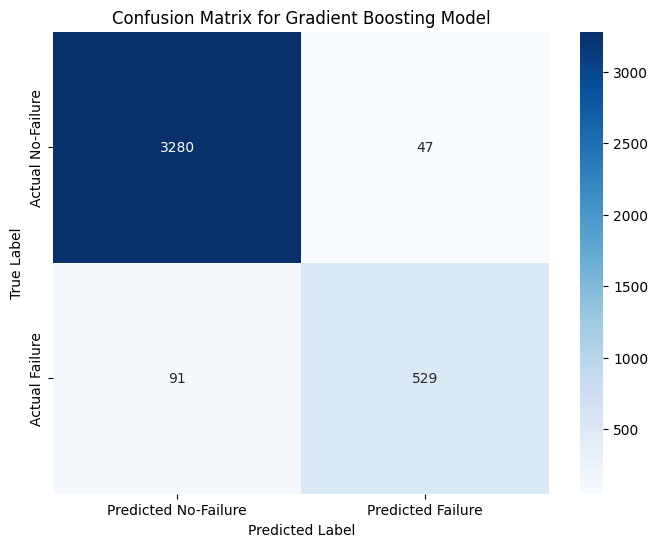

In [3]:
# Define features (X) and target (y)
# The 'engine_id', 'cycle', and 'RUL' columns are not used as features
features = [col for col in train_df.columns if 'sensor' in col or 'setting' in col]
X = train_df[features]
y = train_df['label']

# Split the data into training and validation sets
# `stratify=y` ensures the proportion of high-risk cases is the same in both sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Initialize and train the Gradient Boosting Classifier
# We'll use a learning_rate to control the contribution of each tree,
# and n_estimators to control the number of boosting stages.
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_gb = gb_model.predict(X_val)

# Evaluate the model's performance
print("Model Evaluation on Validation Set:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_gb):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_gb, target_names=['No-Failure', 'Failure']))

# Visualize the confusion matrix to understand prediction errors
cm_gb = confusion_matrix(y_val, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No-Failure', 'Predicted Failure'], yticklabels=['Actual No-Failure', 'Actual Failure'])
plt.title('Confusion Matrix for Gradient Boosting Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Model Evaluation & Results Analysis

This section presents the performance of our new **Gradient Boosting Classifier** and analyzes its effectiveness as a predictive maintenance tool. Our goal is to assess how well the model can identify potential failures to serve as a reliable early warning system.

#### Summary of Key Performance Metrics

-   **Accuracy: 96.50%**
    While a high accuracy score is encouraging, it's important to note that this metric can be misleading in an imbalanced dataset where failures are rare. Therefore, we focus on other specialized metrics for a clearer picture.

-   **Precision: 0.92 (for the 'Failure' class)**
    When our model predicts a failure, it is correct **92% of the time**. This is a great result, as it indicates a low number of false alarms, which helps us avoid unnecessary inspections.

-   **Recall: 0.85 (for the 'Failure' class)**
    This is the most critical metric for our project. A recall of **0.85** means our model successfully identifies **85% of all actual engine failures**. This is a strong indicator that the model is highly effective at catching impending faults, which is our primary goal.

-   **F1-Score: 0.88 (for the 'Failure' class)**
    The F1-Score provides a balanced view of both Precision and Recall. A score of **0.88** shows that our model has a strong balance between avoiding false alarms and catching real failures.

---

#### Conclusion

The **Gradient Boosting Classifier** has proven to be a very strong predictive model for our task. Its high **Recall (85%)** is particularly valuable for our use case, as it means we can confidently rely on this model to flag high-risk machines and prevent a significant majority of unplanned shutdowns. This makes it an excellent choice for a first-pass analysis.